# This notebook contains a toy example for multitask learning under smoothness

References:
- R. Nassif, S. Vlaski, C. Richard, J. Chen and A. H. Sayed, "Multitask Learning Over Graphs: An Approach for Distributed, Streaming Machine Learning," in IEEE Signal Processing Magazine, vol. 37, no. 3, pp. 14-25, May 2020, doi: 10.1109/MSP.2020.2966273. [IEEE Link](https://ieeexplore.ieee.org/document/9084370) or [arXiv](https://arxiv.org/abs/2001.02112)
- R. Nassif, S. Vlaski, C. Richard and A. H. Sayed, "Learning Over Multitask Graphs—Part I: Stability Analysis," in IEEE Open Journal of Signal Processing, vol. 1, pp. 28-45, 2020, doi: 10.1109/OJSP.2020.2989038. [IEEE Link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9075197)
- R. Nassif, S. Vlaski, C. Richard and A. H. Sayed, "Learning Over Multitask Graphs—Part II: Performance Analysis," in IEEE Open Journal of Signal Processing, vol. 1, pp. 46-63, 2020, doi: 10.1109/OJSP.2020.2989031. [IEEE Link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9075192)


## Settings: 

$\color{blue}{\text{Mean-square-error (MSE)}}$ network of $N=50$ nodes is considered. In the MSE multitask network, at each time instant $i$, each agent $k$ is collecting data $\{\boldsymbol{d}_k(i),\boldsymbol{u}_{k,i}\}$ related according to:
$$\boldsymbol{d}_k(i)=\boldsymbol{u}_{k,i}^\top w^o_k+\boldsymbol{v}_k(i)$$
where $\boldsymbol{v}_k(i)$ is a zero-mean Gaussian noise with variance $\sigma^2_{v,k}$ and $\boldsymbol{u}_{k,i}$ is an $M\times 1$ regression vector randomly generated from the Gaussian distribution $\mathcal{N}(0,\sigma^2_{u,k}I_{M})$.

### 1- Graph topology:  
The symetric $\color{blue}{\text{adjacency matrix $A$}}$ of the graph is provided. The $\color{blue}{\text{graph Laplacian}}$ is first computed according to $L=D-A$ ($D$ is the diagonal degree matrix), and then its $\color{blue}{\text{eigendecomposition}}$ $L=V\Lambda V^\top$ is performed.

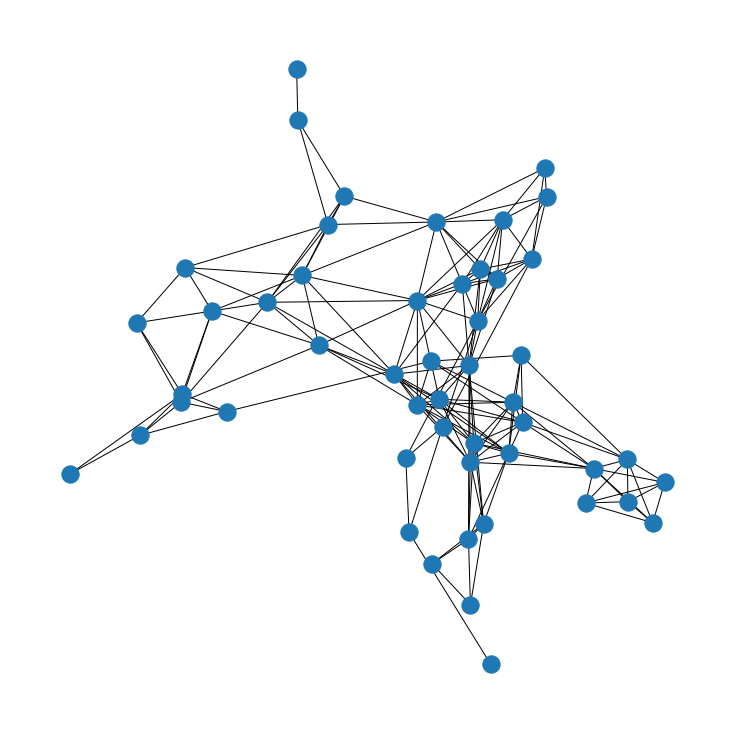

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.spatial
%matplotlib inline 

N=50 # number of nodes
thres=0.25 # the smaller thres is, the sparser the graph will be
sigma2=0.1**2
nodes_coordinates=np.random.rand(N,2)
Dist=scipy.spatial.distance.pdist(nodes_coordinates)
D=scipy.spatial.distance.squareform(Dist)
D1= D<=thres
D_thres=np.multiply(D,D1.astype(int))
A=np.multiply(D_thres,np.exp(-(np.square(D_thres)/(2*sigma2))))# Adjacency matrix

D=np.diag(np.sum(A,axis=1)) # Creating the degree matrix
L=D-A # The graph Laplacian
Lambda,V=np.linalg.eig(L)
idx = Lambda.argsort()[::1] # Sorting the eigenvalues in ascending order
Lambda = Lambda[idx] # Sorting the eigenvalue vector accordingly
V = V[:,idx] # Sorting the eigenvector matrix accordingly

Adj= A>=10e-5
G=nx.from_numpy_matrix(A)
plt.figure(1,figsize=(10,10))
nx.draw(G)

np.save('adjacency.npy', A)

### 2- Variances generation: 
The $\color{blue}{\text{variances $\left\{\sigma^2_{u,k},\sigma^2_{v,k}\right\}$}}$ are randomly generated from the uniform distributions as shown below.

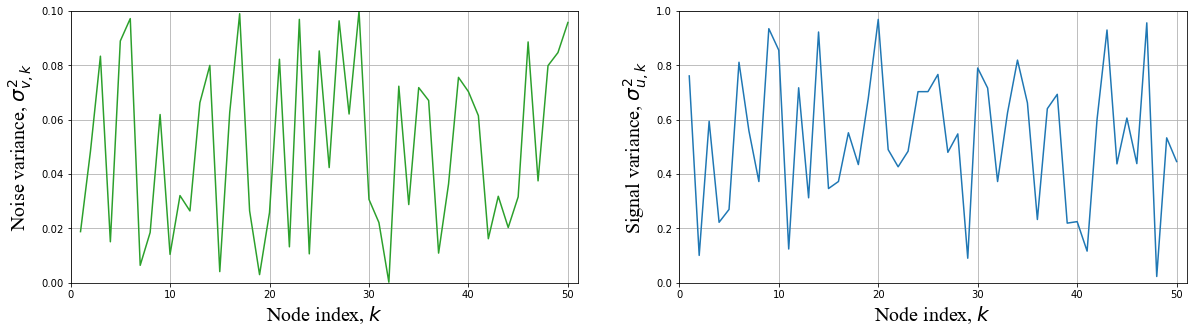

In [20]:
var_v=0.1*np.random.rand(N,1) # The noise variances 
var_u=np.random.rand(N,1) # The signal variances 

# Illustration of the noise and signal spatial distributions:
plt.figure(2,figsize=(20,5))
plt.subplot(121)
plt.plot(range(1,N+1),var_v, "C2")
plt.xlabel('Node index, $k$',fontsize=20,fontname='times new roman' )
plt.ylabel('Noise variance, $\sigma^2_{v,k}$',fontsize= 20,fontname='times new roman' )
plt.xlim(0,N+1)
plt.ylim(0,0.1)
plt.grid()
plt.subplot(122)
plt.plot(range(1,N+1),var_u)
plt.xlabel("Node index, ${k}$",fontsize=20,fontname='times new roman')
plt.ylabel('Signal variance, $\sigma^2_{u,k}$',fontsize=20,fontname='times new roman' )
plt.xlim(0,N+1)
plt.ylim(0,1)
plt.grid()
plt.show()

### 3- Parameter vectors (commonly referred to as tasks or objectives) generation:
The objective at agent $k$ is to estimate the $M\times 1$ parameter vector $w^o_k$. We set $M=5$. The $\color{blue}{\text{objectives $\{w^o_k\}$}}$ are generated according to:
1. Generating an $NM\times 1$ random vector ${\scriptstyle{\mathcal{W}}}_0$;
2. Moving to the frequency domain by computing the graph Fourier transform of ${\scriptstyle{\mathcal{W}}}_0$ according to:
$$\overline{\scriptstyle{\mathcal{W}}}_0=\text{GFT}({\scriptstyle{\mathcal{W}}}_0)=\mathcal{V}^\top {\scriptstyle{\mathcal{W}}}_0$$
where $\mathcal{V}=V\otimes I_M$.
3. Filtering in the frequency domain by cutting the high-frequencies according to:
$$\overline{\scriptstyle{\mathcal{W}}}'_0=e^{-\tau(\Lambda\otimes I_M)}{\scriptstyle{\mathcal{W}}}_0$$
The value of $\tau>0$ controls the smoothness of the graph signal. The larger $\tau$ is, the smoother the graph signal ${\scriptstyle{\mathcal{W}}}^o$ will be.
4. Moving back to the spatial domain by computing the inverse graph Fourier transform:
$${\scriptstyle{\mathcal{W}}}^o=\text{IGFT}\left(\overline{\scriptstyle{\mathcal{W}}}'_0\right)=\mathcal{V}\overline{\scriptstyle{\mathcal{W}}}'_0$$
5. Set $w^o_k$, the objective at agent $k$, as the $k$-th sub-vector of ${\scriptstyle{\mathcal{W}}}^o$.

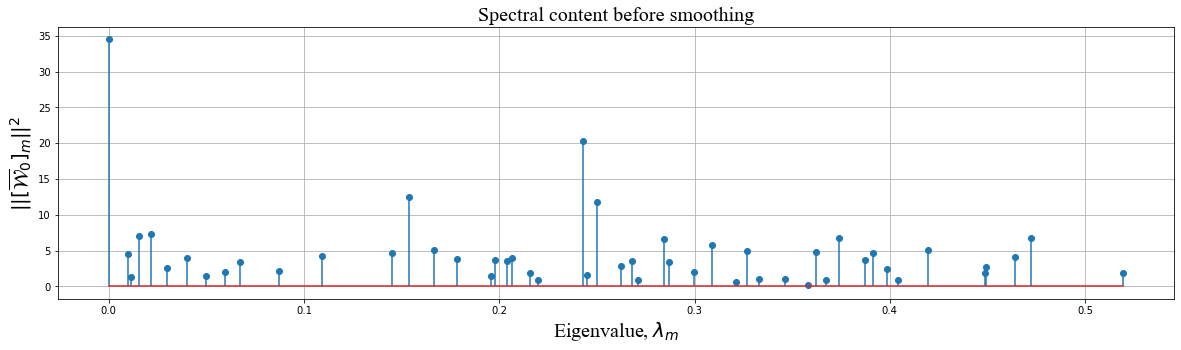

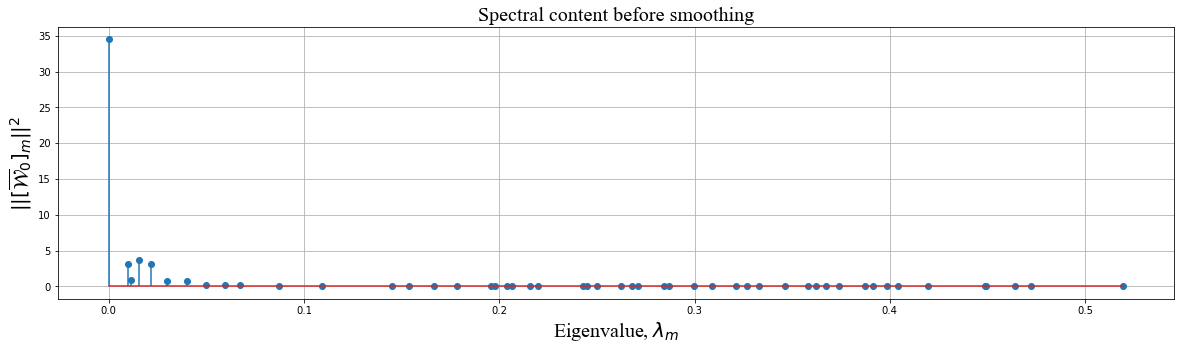

Before smoothing the signal, S= [[46.47378329]]
After smoothing the signal, S= [[0.27889294]]


In [39]:
M=4 # Length of the network parameter vectors
w_0=0.5+1*np.random.randn(N*M,1) # Generating an NM-dimensional vector from the gaussian distribution with variance 1 and mean 0.5
np.save('w_0.npy', w_0)

cL=np.kron(L, np.eye(M))
s0=np.matmul(np.matmul(w_0.T,cL),w_0)# smoothness of the original vector

cV=np.kron(V, np.eye(M))
TFw_0=np.matmul(cV.T,w_0)# Graph Fourier transform of the vector w_0

# Illustration of the Fourier transform content (before smoothing):
TFw_0_reshape=np.reshape(TFw_0,(M,N),order='F')
content=np.diag(np.matmul(TFw_0_reshape.T,TFw_0_reshape))
plt.figure(3,figsize=(20,5))
plt.stem(Lambda,content, use_line_collection = True)
plt.xlabel('Eigenvalue, $\lambda_m$',fontsize=20,fontname='times new roman')
plt.ylabel('$\||[\overline{\mathcal{W}}_0]_m\||^2$',fontsize= 20,fontname='times new roman')
plt.title('Spectral content before smoothing',fontsize=20,fontname='times new roman')
plt.grid()
plt.show()

# Smoothing the signal
tau=20 # smoothing factor
kernel=np.kron(np.diag(np.exp(-tau*Lambda)),np.eye(M))
TFw_0_smooth=np.matmul(kernel,TFw_0)
TFw_0_smooth_reshape=np.reshape(TFw_0_smooth,(M,N),order='F')
content_smooth=np.diag(np.matmul(TFw_0_smooth_reshape.T,TFw_0_smooth_reshape))
plt.figure(4,figsize=(20,5))
plt.stem(Lambda,content_smooth, use_line_collection = True)
plt.xlabel('Eigenvalue, $\lambda_m$',fontsize=20,fontname='times new roman')
plt.ylabel('$\||[\overline{\mathcal{W}}_0]_m\||^2$',fontsize= 20,fontname='times new roman')
plt.title('Spectral content before smoothing',fontsize=20,fontname='times new roman')
plt.grid()
plt.show()

w_0_smooth=np.matmul(cV,TFw_0_smooth)
s1=np.matmul(np.matmul(w_0_smooth.T,cL),w_0_smooth)# smoothness of the smoothed vector
print('Before smoothing the signal, S=',s0)
print('After smoothing the signal, S=', s1)

tasks=np.reshape(w_0_smooth,(M,N),order='F')

